<a href="https://colab.research.google.com/github/more0artie/CreditCardAnomalyDetectionDashboard/blob/main/Copy_of_CreditCardAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# creditcard_isoforest.py
"""
IsolationForest on Credit Card Fraud dataset (creditcard.csv)
Assumes the CSV has columns: Time, V1..V28, Amount, Class (0 = normal, 1 = fraud)
"""

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
RANDOM_STATE = 42

In [ ]:
# def load_data(path="creditcard.csv"):
#     df = pd.read_csv(path)
#     return df
def load_data(path):
    df = pd.read_csv(path)

    # Remove rows where Class is missing
    df = df.dropna(subset=["Class"])

    # Remove any other NaNs just in case
    df = df.dropna().reset_index(drop=True)

    # Ensure Class is integer (sometimes gets parsed wrong)
    df["Class"] = df["Class"].astype(int)


    return df


In [ ]:
# def preprocess(df):
#     # Keep features and label
#     features = [c for c in df.columns if c not in ["Class"]]
#     X = df[features].copy()
#     y = df["Class"].copy()

#     # Scale Time and Amount (V1..V28 are already PCA components in the usual dataset)
#     scaler = StandardScaler()
#     X[["Time", "Amount"]] = scaler.fit_transform(X[["Time", "Amount"]])

#     return X, y, scaler
def preprocess(df):
    df = df.dropna().reset_index(drop=True)
    print("NaNs in entire DF:\n", df.isna().sum())
    print("Unique values in Class:", df["Class"].unique())
    print(df.columns.tolist(), "I'm here")
    features = [c for c in df.columns if c not in ["Class"]]
    X = df[features].copy()
    y = df["Class"].copy()

    scaler = StandardScaler()
    X[["Time", "Amount"]] = scaler.fit_transform(X[["Time", "Amount"]])

    return X, y, scaler



In [ ]:
def train_isolation_forest(X_train, contamination):
    # Initialize model
    model = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination=contamination,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    # Fit on training data (should be mostly normal transactions)
    model.fit(X_train)
    return model

In [ ]:
def predict_anomalies(model, X):
    """
    IsolationForest.predict -> {1: normal, -1: anomaly}
    We'll convert to binary labels: pred_label = 1 if anomaly, 0 if normal
    Also return anomaly score (higher means more normal by default with decision_function)
    """
    raw_pred = model.predict(X)
    pred_label = (raw_pred == -1).astype(int)  # 1 = anomaly (fraud), 0 = normal
    anomaly_score = -model.decision_function(X)  # make higher = more anomalous
    return pred_label, anomaly_score

In [ ]:
def evaluate(y_true, y_pred, anomaly_score):
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, anomaly_score)
    except ValueError:
        auc = np.nan

    metrics = {"precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}
    print("\nKey metrics:", metrics)
    return metrics, cm


In [ ]:
def plot_roc(y_true, anomaly_score):
    fpr, tpr, _ = roc_curve(y_true, anomaly_score)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1], [0,1], linestyle="--", lw=1, color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve (IsolationForest anomaly score)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(y_true == y_pred)


Loaded data shape: (284807, 31)
NaNs in entire DF:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Unique values in Class: [0 1]
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'] I'm here
Train shape: (227845, 30) Test shape: (56962, 30)
Train fraud ratio: 0.001729245759178389 Test fraud ratio: 0.0017204452090867595
Training only on normal transactions shape: (227451, 30)
Global fraud ratio (dataset): 0.001727485630620034
Using contamination = 0.001727485630620034
Confusion Matrix:
[[56764   

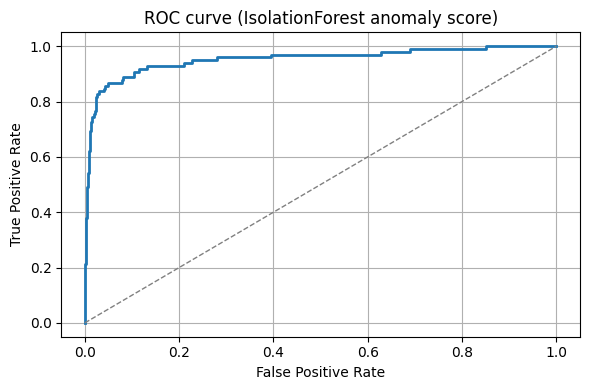


Top anomalous rows (preview):
        anomaly_score  is_fraud
102444       0.058789         1
102442       0.058789         1
153835       0.058730         1
151008       0.057852         1
15810        0.043257         1
...               ...       ...
204064      -0.076601         1
77348       -0.078735         1
149577      -0.079750         1
149869      -0.086300         1
6529        -0.089466         1

[73 rows x 2 columns]
            Time         V1         V2         V3        V4         V5  \
102444 -0.560285 -13.192671  12.785971  -9.906650  3.320337  -4.801176   
102442 -0.560285 -13.192671  12.785971  -9.906650  3.320337  -4.801176   
153835  0.115485 -22.341889  15.536133 -22.865228  7.043374 -14.183129   
151008 -0.009515 -26.457745  16.497472 -30.177317  8.904157 -17.892600   
15810  -1.422712 -25.942434  14.601998 -27.368650  6.378395 -19.104033   
...          ...        ...        ...        ...       ...        ...   
204064  0.848237   0.232512   0.938944  -4.6

In [ ]:
def main(path="creditcard.csv", test_size=0.2):
    df = load_data(path)
    print("Loaded data shape:", df.shape)
    X, y, scaler = preprocess(df)

    # 1) split (we keep some frauds in test to evaluate detection ability)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
    print("Train fraud ratio:", y_train.mean(), "Test fraud ratio:", y_test.mean())

    # 2) Train only on normal transactions (common unsupervised set-up)
    X_train_clean = X_train[y_train == 0]
    print("Training only on normal transactions shape:", X_train_clean.shape)

    # 3) choose contamination (expected fraction of outliers)
    # recommended: set to true fraud ratio in dataset (or slightly higher)
    global_contamination = y.mean()
    print("Global fraud ratio (dataset):", global_contamination)
    contamination = global_contamination  # you may tune this
    print("Using contamination =", contamination)

    # 4) Train model
    model = train_isolation_forest(X_train_clean, contamination=contamination)

    # 5) Predict on test set
    y_pred, anomaly_score = predict_anomalies(model, X_test)

    # 6) Evaluate
    metrics, cm = evaluate(y_test, y_pred, anomaly_score)
    pred = model.predict(X_test)
    print("Accuracy YAHA HAI:", accuracy_score(y_test, y_pred))
    print("Accuracy YAHA HAI 2:", accuracy_score(y_test, (y_pred == -1).astype(int)))

    # 7) Optional: ROC curve
    plot_roc(y_test, anomaly_score)

    # 8) Show top anomalous examples
    top_n = 1000
    test_with_scores = X_test.copy()
    test_with_scores["is_fraud"] = y_test.values
    test_with_scores["anomaly_score"] = anomaly_score
    top_anomalies = test_with_scores.sort_values("anomaly_score", ascending=False).head(top_n)
    print("\nTop anomalous rows (preview):")
    # print(top_anomalies[["anomaly_score", "is_fraud"]].head(top_n))
    fraud_rows = top_anomalies[top_anomalies["is_fraud"] == 1]
    print(fraud_rows[["anomaly_score", "is_fraud"]])
    print(fraud_rows, "fraud row data")
    return model, scaler, metrics, cm, top_anomalies

if __name__ == "__main__":
    model, scaler, metrics, cm, top_anomalies = main("creditcard.csv", test_size=0.2)

In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [2]:
!git clone https://github.com/more0artie/CreditCardAnomalyDetectionDashboard


Cloning into 'CreditCardAnomalyDetectionDashboard'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 32.44 KiB | 8.11 MiB/s, done.


In [1]:
!ls

sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive
!ls


/content/drive/MyDrive
 12th_markssheet.jpeg
'All photos 5 Nov 2023'
'CANDIDATE DECLARATION FORM MSI Services.docx'
 chess-20221009T151538Z-001
 cisce.org-SSCER-166128698.pdf
 Classroom
'Colab Notebooks'
 CreditCardAnomalyDetection
 data.csv
 DE_SOLUTION_Sanjana_Sinha
'dof-pmrj-yfp - Nov 3, 2022.pdf'
 Final_resume_Sanjana_Dec.pdf
'Google AI Studio'
 housing.gsheet
 index.gdoc
'mca (1).pdf'
'MODULE-01 (1).gdoc'
 MODULE-01.gdoc
'Module 4 (1) (1).gdoc'
'Module 4 (1).gdoc'
 MODULE_5_CHAPTER_9_NOTES.gdoc
'Preboarding form.xlsx'
 pythonProject
 research.csv
'Resume (1).gdoc'
'Resume (2).gdoc'
 Resume.gdoc
'Resume of Sanjana Sinha - CoCubes.com.pdf'
 Resume.pdf
'Sanjana Sinha 4th sem marks card (1).pdf'
'Sanjana Sinha 4th sem marks card.pdf'
'Sanjana Sinha_FINAL (1).pdf'
'Sanjana Sinha_FINAL.pdf'
'Sanjana Sinha ID Card.pdf'
'Sanjana Sinha Resume.pdf'
'Sanjana_Sinha_rseume_ss (2)_removed.pdf'
 Screenshot_20230419_123523.jpg
'WhatsApp Image 2022-07-07 at 5.39.36 PM.jpeg'


In [4]:
%cd CreditCardAnomalyDetection

/content/drive/MyDrive/CreditCardAnomalyDetection


In [5]:
!ls -a

'Copy of CreditCardAnomalyDetection.ipynb'   creditcard.csv
 CreditCardAnomalyDetectionDashboard


In [6]:
%cd CreditCardAnomalyDetectionDashboard/

/content/drive/MyDrive/CreditCardAnomalyDetection/CreditCardAnomalyDetectionDashboard


In [8]:
!ls -a

Copy_of_CreditCardAnomalyDetection.ipynb  .git	README.md


In [10]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Copy_of_CreditCardAnomalyDetection.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
